In [8]:
# Dependencies
import requests
import pandas as pd
from census import Census
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
from config import api_key

In [24]:
## Pulling Median Income By County (CA)

years = [2018,2019,2021,2022] # no 2020 data available due to COVID -19
med_income_var = 'B19013_001E'
base_url = 'https://api.census.gov/data/'
geo = '&for=county:*&in=state:06'  # California = 06
dfs = []

for year in years: 
    url = f'{base_url}{year}/acs/acs1?get={med_income_var}{geo}&key={api_key}'
    
    data = requests.get(url).json()

    data = pd.DataFrame(data[1:])
   
    data["Year"] = year

    data = data.rename(columns={0: 'Median Income',1: 'State',2:'County'})
    dfs.append(data)

income_data_county = pd.concat(dfs, ignore_index=True)
income_data_county['State'] = pd.to_numeric(income_data_county['State'])
income_data_county['County'] = pd.to_numeric(income_data_county['County'])
income_data_county["Median Income"] = income_data_county["Median Income"].astype('int')
income_data_county

,Median Income,State,County,Year
0,48554,6,33,2018
1,57745,6,47,2018
2,101618,6,13,2018
3,60321,6,99,2018
4,77472,6,83,2018
...,...,...,...,...
160,58884,6,103,2022
161,64722,6,107,2022
162,102569,6,111,2022
163,83875,6,113,2022


In [14]:
## Pulling Median Income By State (CA)

years = [2018,2019,2021,2022] # no 2020 data available due to COVID -19
med_income_var = 'B19013_001E'
base_url = 'https://api.census.gov/data/'
geo = '&for=state:06'  # California = 06
dfs = []

for year in years: 
    url = f'{base_url}{year}/acs/acs1?get={med_income_var}{geo}&key={api_key}'

    data = requests.get(url).json()

    data = pd.DataFrame(data[1:])
   
    data["Year"] = year

    data = data.rename(columns={0: 'Median Income',1: 'State',2:'County'})
    dfs.append(data)

income_data_state = pd.concat(dfs, ignore_index=True)
income_data_state['State'] = pd.to_numeric(income_data_state['State'])
income_data_state["Median Income"] = income_data_state["Median Income"].astype('int')
income_data_state

,Median Income,State,Year
0,75277,6,2018
1,80440,6,2019
2,84907,6,2021
3,91551,6,2022


In [15]:
#Pulling Geocodes for State(CA)
geocodes_csv = "../Josh/Resources/geocodes.csv"
geo_state = pd.read_csv(geocodes_csv)
geo_state = geo_state.rename(columns={"Area Name (including legal/statistical area description)":"Area","State Code (FIPS)":"State"})
geo_state = geo_state[(geo_state['State']== 6) & (geo_state["County Code (FIPS)"]==0) *(geo_state["Place Code (FIPS)"] == 0)]
geo_state = geo_state[["State","Area"]]
geo_state

,State,Area
1393,6,California


In [16]:
#Pulling Geocodes for County(CA)
geocodes_csv = "../Josh/Resources/geocodes.csv"
geo_county = pd.read_csv(geocodes_csv)
geo_county = geo_county.rename(columns={"Area Name (including legal/statistical area description)":"Area","State Code (FIPS)":"State","County Code (FIPS)":"County"})
geo_county = geo_county[['State','County','Area']]
geo_county = geo_county[(geo_county['State']== 6) & (geo_county["County"] > 0)]
geo_county.head()

,State,County,Area
1394,6,1,Alameda County
1395,6,3,Alpine County
1396,6,5,Amador County
1397,6,7,Butte County
1398,6,9,Calaveras County


In [17]:
#Created CSV for Regions in case we want to do Socal/NorCal Analysis
state_split_csv = "../Josh/Resources/California - Counties.csv"
state_split = pd.read_csv(state_split_csv)
state_split.head()

,County,Region
0,Alameda County,NorCal
1,Alpine County,NorCal
2,Amador County,NorCal
3,Butte County,NorCal
4,Calaveras County,NorCal


In [18]:
#Merging DF's for County Names
data_county = pd.merge(income_data_county,geo_county,on=['State','County'],how='left')
data_county.drop(columns=["County"], inplace=True)
data_county.rename(columns={'Area': 'County'},inplace=True)
data_county['State'] = 'California'
data_county  = pd.merge(data_county,state_split, on= "County",how='left')
data_county = data_county[['Year', 'State','Region','County','Median Income']]
data_county.head()

,Year,State,Region,County,Median Income
0,2018,California,NorCal,Lake County,48554
1,2018,California,NorCal,Merced County,57745
2,2018,California,NorCal,Contra Costa County,101618
3,2018,California,NorCal,Stanislaus County,60321
4,2018,California,SoCal,Santa Barbara County,77472


In [19]:
#Merging DF's for State Name (Can easily rename column to 'California' but merging will ensure accuracy of pull)
data_state = pd.merge(income_data_state,geo_state,on=['State'],how='left')
data_state.drop(columns=["State"],inplace=True)
data_state.rename(columns={"Area":"State"},inplace=True)
data_state = data_state[["Year","State","Median Income"]]
data_state

,Year,State,Median Income
0,2018,California,75277
1,2019,California,80440
2,2021,California,84907
3,2022,California,91551


In [20]:
#Working with Median Housing Price Data - Cleaning up and getting Mean by year

pd.set_option('display.float_format', '{:.2f}'.format)

csv = "../Josh/Resources/Median(New) - MedianPricesofExistingDetachedHomesHistoricalData.csv"

median_data = pd.read_csv(csv)

median_data = median_data.drop('Unnamed: 54',axis=1)
median_data = median_data.astype('str')

def clean_currency(value):
    try:
        return int(str(value).replace(',', '').replace('$', ''))
    except ValueError:
        # Return np.nan for non-convertible values
        return np.nan

columns_to_clean = ['CA', 'Alameda', 'Amador', 'Butte', 'Calaveras',
       'Contra-Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin',
       'Mariposa', 'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Nevada',
       'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus',
       'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo',
       'Yuba', 'Condo', 'LA Metro', 'Central Coast', 'Central Valley',
       'Far North', 'Inland Empire', 'S.F. Bay Area', 'SoCal']
median_data[columns_to_clean] = median_data[columns_to_clean].applymap(clean_currency)
median_data["Mon-Yr"] = pd.to_datetime(median_data["Mon-Yr"],format='%b-%y')
median_data = median_data[median_data["Mon-Yr"] >= "2018-01-01"]

median_data["Year"] = median_data["Mon-Yr"].dt.year
median_data = median_data[['Year', 'CA', 'Alameda', 'Amador', 'Butte', 'Calaveras',
       'Contra-Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin',
       'Mariposa', 'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Nevada',
       'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus',
       'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo',
       'Yuba']]
median_data.reset_index().drop(columns=["index"])
median_grp = median_data.groupby("Year")

median_data = median_grp.mean().reset_index()
median_data

,Year,CA,Alameda,Amador,Butte,Calaveras,Contra-Costa,Del Norte,El Dorado,Fresno,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
0,2018,571057.50,926358.33,327476.67,320112.50,321708.33,649169.17,230191.67,491687.42,268630.83,...,667375.00,312658.33,293766.67,219012.50,NaN,232981.67,295350.83,654005.83,439729.17,278813.33
1,2019,591865.83,911500.00,324687.50,361633.33,339101.67,661736.67,261485.83,497453.33,281920.83,...,655243.33,326854.17,310212.50,255875.00,258329.17,243641.67,301125.00,651220.83,452575.83,294937.50
2,2020,650156.67,1001271.67,346366.67,384780.83,366409.17,737000.00,290100.00,529164.17,309070.83,...,695219.17,359583.33,339108.33,276604.17,296495.83,267141.67,317875.00,714145.83,485400.83,333161.67
3,2021,785640.83,1242958.33,421805.83,434448.33,459687.50,902541.67,365845.83,646720.00,367208.33,...,767266.67,425541.67,399816.67,327787.50,327479.17,318210.00,380051.67,819937.50,575560.83,401433.33
4,2022,821204.17,1306546.67,418425.00,446898.33,473070.83,903200.00,375087.50,671083.33,408416.67,...,826887.50,455695.00,431525.00,327394.17,303500.00,357455.83,413500.83,886541.67,623743.33,428329.17
5,2023,811128.89,1221111.11,445243.33,427863.33,480388.89,853632.22,352388.89,653413.33,409376.67,...,831598.89,450738.89,414500.00,321958.89,316343.75,361255.56,407450.00,889444.44,601711.11,435237.78


In [21]:
#melt(take columns and make them rows) Housing Median Price DF into two DFS: One For CA and one by County.  
# Also merging with Median Income DF's 

melted_df = pd.melt(median_data, id_vars=['Year'], var_name='Region', value_name='Median Housing Price')
melted_df["Region"] = melted_df["Region"] + " County"
melted_df.loc[melted_df['Region'] == 'CA County', 'Region'] = 'California'

#create county DF(Housing Prices)
housing_county = melted_df[melted_df['Region']!= 'California'].copy()
housing_county.rename(columns={"Region":"County"},inplace=True)

#create state DF (Housing Prices)
housing_state = melted_df[(melted_df['Region']== 'California') & (melted_df['Year'] != 2020) & (melted_df["Year"] != 2023)].copy()

housing_state = housing_state.reset_index().drop(columns=['index'])
housing_state.rename(columns={"Region":"State"},inplace=True)
state_df = pd.merge(data_state,housing_state,on=["Year","State"])
county_df = pd.merge(data_county,housing_county,on=["Year","County","County"])

In [26]:
#Store counties as a list for x-axis

median_price_counties=['Alameda', 'Amador', 'Butte', 'Calaveras',
       'Contra-Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin',
       'Mariposa', 'Mendocino', 'Merced', 'Mono', 'Monterey', 'Napa', 'Nevada',
       'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus',
       'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo',
       'Yuba']
print(len(median_price_counties))

#Store housing prices for 2018, 2019, 2020, 2021, 2022, and 2023

#2018 
median_price_2018 = median_data.loc[[0], :].values.flatten().tolist()
del median_price_2018[0]

#2019
median_price_2019 = median_data.loc[[1], :].values.flatten().tolist()
del median_price_2019[0]

#2020
median_price_2020 = median_data.loc[[2], :].values.flatten().tolist()
del median_price_2020[0]

#2021
median_price_2021 = median_data.loc[[3], :].values.flatten().tolist()
del median_price_2021[0]

#2022
median_price_2022 = median_data.loc[[4], :].values.flatten().tolist()
del median_price_2022[0]

#2023
median_price_2023 = median_data.loc[[5], :].values.flatten().tolist()
del median_price_2023[0]

52


In [38]:
#Divide Counties into Northern/Southern CA Counties 
def remove_counties(c):
    return c.replace(" County", "")

#Northern CA DataFrame
norcal_counties=county_df.loc[county_df['Region']=='NorCal', 'County'].map(remove_counties).tolist()
norcal_df=median_data[['Year',*norcal_counties]].copy()
print(norcal_df)


#Southern CA DataFrame 
socal_counties=county_df.loc[county_df['Region']=='SoCal', 'County'].map(remove_counties).tolist()
print(socal_counties)

   Year      Lake    Merced  Stanislaus  Sacramento  El Dorado  Monterey  \
0  2018 269408.33 268086.67   312658.33   365454.17  491687.42 618520.83   
1  2019 265908.33 279136.67   326854.17   379437.50  497453.33 630105.00   
2  2020 294245.83 301350.00   359583.33   416749.17  529164.17 750541.67   
3  2021 338235.00 349625.00   425541.67   499083.33  646720.00 854083.33   
4  2022 350866.67 385948.33   455695.00   536500.00  671083.33 864791.67   
5  2023 326527.78 384580.00   450738.89   522666.67  653413.33 885078.89   

   San Francisco    Tulare  Humboldt  ...  Santa Cruz    Shasta    Solano  \
0     1573333.33 232981.67 311112.50  ...   882375.00 265287.50 442833.33   
1     1589416.67 243641.67 322046.67  ...   889854.17 284626.67 449056.67   
2     1646125.00 267141.67 338136.67  ...   972833.33 307554.17 489754.17   
3     1810700.00 318210.00 408544.17  ...  1186204.17 359112.50 565062.50   
4     1775333.33 357455.83 445941.67  ...  1319583.33 378729.17 599041.67   
5    

In [51]:
print(len(norcal_counties))
print(len(median_price_counties))

121
52


[269408.3333333333, 268086.6666666667, 312658.3333333333, 365454.1666666667, 491687.4166666667, 618520.8333333334, 1573333.3333333333, 232981.66666666666, 311112.5, 261362.5, 882375.0, 1344328.3333333333, 480125.8333333333, 265287.5, 442833.3333333333, 320112.5, 232723.33333333334, 268630.8333333333, 293766.6666666667, 1580333.3333333333, 367850.0, 278813.3333333333, 667375.0, 926358.3333333334, 704833.3333333334, 439729.1666666667, 412640.6666666667, 419929.1666666667, 1318250.0, 269408.3333333333, 278813.3333333333, 667375.0, 926358.3333333334, 704833.3333333334, 439729.1666666667, 412640.6666666667, 419929.1666666667, 1318250.0, 268086.6666666667, 312658.3333333333, 219012.5, 365454.1666666667, 491687.4166666667, 618520.8333333334, 1573333.3333333333, 232981.66666666666, 311112.5, 261362.5, 882375.0, 1344328.3333333333, 480125.8333333333, 265287.5, 442833.3333333333, 320112.5, 232723.33333333334, 268630.8333333333, 293766.6666666667, 1580333.3333333333, 367850.0, 232723.33333333334,

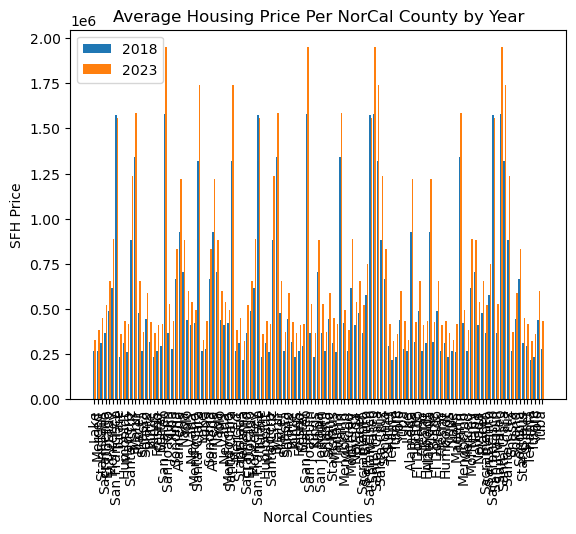

In [49]:
#practice bar graph
X=norcal_counties

norcal_median_2018=norcal_df.loc[[0],:].values.flatten().tolist()
del norcal_median_2018[0]
print(norcal_median_2018)

norcal_median_2023=norcal_df.loc[[5],:].values.flatten().tolist()
del norcal_median_2023[0]
print(norcal_median_2023)

Y=norcal_median_2018
Z=norcal_median_2023

X_axis=np.arange(len(X))

plt.bar(X_axis - 0.2, norcal_median_2018, 0.4, label='2018')
plt.bar(X_axis +0.2, norcal_median_2023, 0.4, label='2023')

plt.xticks(X_axis,X, rotation="vertical")
plt.xlabel("Norcal Counties")
plt.ylabel("SFH Price")
plt.title("Average Housing Price Per NorCal County by Year")
plt.legend()
plt.show()

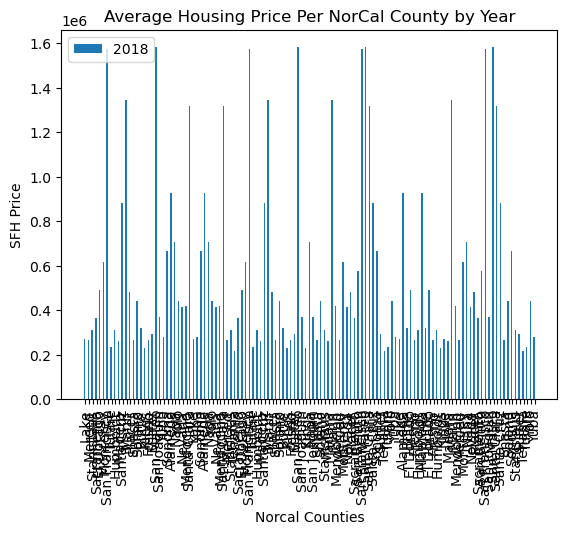

In [48]:
#Bar Graph - median single family home price per California county (2018)

X=norcal_counties
Y=norcal_median_2018
X_axis=np.arange(len(X))

plt.bar(X_axis - 0.2, norcal_median_2018, 0.4, label='2018')
plt.xticks(X_axis,X, rotation="vertical")
plt.xlabel("Norcal Counties")
plt.ylabel("SFH Price")
plt.title("Average Housing Price Per NorCal County by Year")
plt.legend()
plt.show()

In [ ]:
# Set x axis and tick locations
x_axis = median_price_counties
tick_locations = [value+0.4 for value in x_axis]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,4))
plt.bar(x_axis, median_price_2018, color='r', alpha=0.5, align="edge")
plt.xticks(median_price_counties, rotation="vertical")
plt.show()

In [ ]:
#Bar Graph - median price per California county (2019)

In [ ]:
#Bar Graph - median price per California county (2020)

In [ ]:
#Bar Graph - median price per California county (2021)

In [ ]:
#Bar Graph - median price per California county (2022)

In [ ]:
#Bar Graph - median price per California county (2023)

In [ ]:
#Linear Regression 
def linear_reg(x_axis, y_axis,eq_loc):
    correlation = st.pearsonr(x_axis,y_axis)
    p_slope, p_int, p_r, p_p, p_std_err = st.linregress(x_axis, y_axis)
    regress_values = x_axis * p_slope + p_int
    eq= f"y ={p_slope: .2f}x +{ p_int: .2f}"

    #Plot the line
    plt.scatter(x_axis, y_axis ,marker="o")
    plt.plot(x_axis,regress_values,"r-")
    plt.annotate(eq, eq_loc, fontsize=12, color='red')
    print(f"The r-value is: {p_r**2}")

In [ ]:
northern_hemi_df = city_data_df.loc[city_data_df['Lat']>=0]

In [37]:
#Divide Counties into Northern/Southern CA Counties 
def remove_counties(c):
    return c.replace(" County", "")

#Northern CA DataFrame
norcal_counties=county_df.loc[county_df['Region']=='NorCal', 'County'].map(remove_counties).tolist()
norcal_df=median_data[['Year',*norcal_counties]].copy()
print(norcal_df)


#Southern CA DataFrame 
socal_counties=county_df.loc[county_df['Region']=='SoCal', 'County'].map(remove_counties).tolist()
print(socal_counties)

   Year      Lake    Merced  Stanislaus  Sacramento  El Dorado  Monterey  \
0  2018 269408.33 268086.67   312658.33   365454.17  491687.42 618520.83   
1  2019 265908.33 279136.67   326854.17   379437.50  497453.33 630105.00   
2  2020 294245.83 301350.00   359583.33   416749.17  529164.17 750541.67   
3  2021 338235.00 349625.00   425541.67   499083.33  646720.00 854083.33   
4  2022 350866.67 385948.33   455695.00   536500.00  671083.33 864791.67   
5  2023 326527.78 384580.00   450738.89   522666.67  653413.33 885078.89   

   San Francisco    Tulare  Humboldt  ...  Santa Cruz    Shasta    Solano  \
0     1573333.33 232981.67 311112.50  ...   882375.00 265287.50 442833.33   
1     1589416.67 243641.67 322046.67  ...   889854.17 284626.67 449056.67   
2     1646125.00 267141.67 338136.67  ...   972833.33 307554.17 489754.17   
3     1810700.00 318210.00 408544.17  ...  1186204.17 359112.50 565062.50   
4     1775333.33 357455.83 445941.67  ...  1319583.33 378729.17 599041.67   
5    

In [ ]:
norcal_df2=norcal_df.pivot(index)

In [ ]:
#Housing Prices (y axis) vs Median Income (x axis)Regression Plot 
linear_reg(norcal_counties['Lat'], norcal_counties['Humidity'],(55, 10))
plt.xlabel('Latitude')
plt.ylabel('Humidity(%)')